# DiscreteDP Example: Job Search

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

We study an optimal stopping problem, in the context of job search as discussed in
[http://quant-econ.net/py/lake_model.html](http://quant-econ.net/py/lake_model.html).

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
import numpy as np
import scipy.stats
import scipy.optimize
import scipy.sparse
from numba import jit
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

## Optimal solution

We skip the description of the model, just writing down the Bellman equation:
$$
\begin{aligned}
U   &= u(c) + \beta \left[(1 - \gamma) U + \gamma E[V_s]\right], \\
V_s &= \max\left\{U,
                  u(w_s) + \beta \left[(1 - \alpha) V_s + \alpha U\right]
           \right\}.
\end{aligned}
$$
For this class of problem, we can characterize the solution analytically.

The optimal policy $\sigma^*$ is monotone;
it is characterized by a threshold $s^*$, for which
$\sigma^*(s) = 1$ if and only if $s \geq s^*$,
where actions $0$ and $1$ represent "reject" and "accept", respectively.
The threshold is defined as follows:
Let
$$
\begin{aligned}
g(s) &= u(w_s) - u(c), \\
h(s) &= \frac{\beta \gamma}{1 - \beta (1 - \alpha)}
        \sum_{s' \geq s} p_s u(w_s).
\end{aligned}
$$
It is easy to see that $g$ is increasing and $h$ is decreasing.
Then the threshold $s^*$ is such that $s \geq s^*$ if and only if $g(s) > h(s)$.

Given $s^*$, the optimal values can be computed as follows:
$$
\begin{aligned}
U &=
\frac{\{1 - (1 - \alpha) \beta\} u(c) + \beta \gamma \sum_{s \geq s^*} p_s u(w_s)}
     {(1 - \beta) \left[\{1 - (1 - \alpha) \beta\} +
                        \beta \gamma \sum_{s \geq s^*} p_s\right]}, \\
V_s &=
\begin{cases}
U & \text{if $s < s^*$} \\
\dfrac{u(w_s) + \alpha \beta U}{1 - (1 - \alpha) \beta} & \text{if $s \geq s^*$}.
\end{cases}
\end{aligned}
$$

The optimal policy defines a Markov chain over $\{\text{unemployed}, \text{employed}\}$.
Its stationary distribution is
$\pi = \left(\frac{\alpha}{\alpha + \lambda}, \frac{\lambda}{\alpha + \lambda}\right)$,
where
$\lambda = \gamma \sum_{s \geq s^*} p(w_s)$;
note that the flow from unemployed to employed is $\lambda$,
while the flow from employed to unemployed is $\alpha$.

The expected value at the stationary distribution is
$$
\pi_0 U + \pi_1 \frac{\sum_{s \geq s^*} p_s V_s}{\sum_{s \geq s^*} p_s}.
$$

The following implements the job search problem with the analytical solution above:

In [3]:
class JobSearchModel(object):
    """
    Job search model.
    
    Parameters
    ----------
    w : array_like(float, ndim=1)
        Array containing wage levels. Must be ordered in ascending order.
    
    pdf : array_like(float, ndim=1)
        Wage distribution.
        
    beta : scalar(float)
        Discount factor
        
    alaph :scalar(float)
        Firing probability.
        
    gamma : scalar(float)
        Wage offer arrival probability.
        
    rho: scalar(float)
        Degree of (constant) relative risk aversion.
        
    """
    def __init__(self, w, pdf, beta, alpha=0, gamma=1, rho=0):
        w = np.asarray(w)
        self.pdf = np.asarray(pdf)
        self.beta, self.alpha, self.gamma, self.rho = beta, alpha, gamma, rho
        self.u_w = self.u(w)
        
    def u(self, y):
        """
        y must be array_like.
        
        """
        rho = self.rho
        small_number = -9999999
        y = np.asarray(y, dtype=float)
        nonpositive = (y <= 0)
        if rho == 1:
            util = np.log(y)
        else:
            util = (y**(1 - rho) - 1)/(1 - rho)
        util[nonpositive] = small_number
        return util
    
    def solve(self, c, *args, **kwargs):
        """
        Solve directly s_star and U and V_s.
        
        """
        S = len(self.u_w)
        
        a0 = 1 - (1 - self.alpha) * self.beta
        a1 = self.beta * self.gamma
        coeff = a1 / a0
        u_c = self.u(np.array([c]))[0]
        s_star = _bisect(self.u_w, self.pdf, u_c, coeff)
        
        C = np.zeros(S, dtype=int)
        C[s_star:] = 1
        
        U = a0 * u_c + a1 * self.u_w[s_star:].dot(self.pdf[s_star:])
        U /= a0 + a1 * self.pdf[s_star:].sum()
        U /= 1 - self.beta
        
        V = np.empty(S)
        V[:s_star] = U
        V[s_star:] = (self.u_w[s_star:] + self.alpha * self.beta * U) / a0
        
        return V, U, C
    
    def stationary_distribution(self, C):
        lamb = self.pdf.dot(C) * self.gamma 
        pi = np.array([self.alpha, lamb])
        pi /= pi.sum()
        return pi
        
            
@jit(nopython=True)
def _bisect(u_w, pdf, u_c, coeff):
    lo = -1
    hi = len(u_w)
    while(lo < hi-1):
        m = (lo + hi) // 2
        lhs = u_w[m] - u_c
        rhs = 0
        for i in range(m+1, len(u_w)):
            rhs += (u_w[i] - u_w[m]) * pdf[i]
        rhs *= coeff
        if lhs > rhs:
            hi = m
        else:
            lo = m
    return hi

For comparison, let us also consider the implementation with the `DiscreteDP` class:

In [4]:
class JobSearchModelDiscreteDP(JobSearchModel):
    """
    Job search model with DiscreteDP.
        
    """
    def __init__(self, w, pdf, beta, alpha=0, gamma=1, rho=0):
        super(JobSearchModelDiscreteDP, self).__init__(w, pdf, beta, alpha, gamma, rho)
        
        # Number of states
        # s = 0, ..., len(w)-1: wage w[s] offered, s = len(w): no offer
        num_states = len(w) + 1
        
        # Number of actions: 0: reject, 1: accept
        num_actions = 2
        
        L = num_states*num_actions - 1
        s_indices, a_indices = np.empty(L), np.empty(L)
        s_indices[-1], a_indices[-1] = len(w), 0
        s_indices[:-1] = np.repeat(np.arange(len(w)), num_actions)
        a_indices[:-1] = np.tile(np.arange(num_actions), len(w))
        
        R0 = np.zeros(L)
        R0[[num_actions*i+1 for i in range(len(w))]] = self.u_w
        
        Q = scipy.sparse.lil_matrix((L, num_states))
        it = np.nditer((s_indices, a_indices))
        for (s, a) in it:
            i = it.iterindex
            if a == 0:
                Q[i, -1] = 1 - self.gamma
                Q[i, :len(w)] = self.pdf*self.gamma
            else:  # if a == 1
                Q[i, s], Q[i, -1] = 1 - self.alpha, self.alpha
                
        self.ddp = DiscreteDP(R0, Q, beta, s_indices, a_indices)
        
        self.num_iter = None
        
    def solve(self, c, *args, **kwargs):
        n, m = self.ddp.num_states, self.ddp.num_actions
        self.ddp.R[[m*i for i in range(n)]] = self.u(np.array([c]))[0]
        res = self.ddp.solve(*args, **kwargs)
        V = res.v[:-1]  # Values of jobs
        U = res.v[-1]  # Value of unemployed
        C = res.sigma[:-1]
        self.num_iter = res.num_iter
        
        return V, U, C

The following paramter values are from [lakemodel_example.py](https://github.com/QuantEcon/QuantEcon.py/blob/master/examples/lakemodel_example.py).

In [5]:
w = np.linspace(0, 175, 201)  # wage grid

# compute probability of each wage level 
logw_dist = scipy.stats.norm(np.log(20.),1)
cdf = logw_dist.cdf(np.log(w))
pdf = cdf[1:]-cdf[:-1]
pdf /= pdf.sum()
w = (w[1:] + w[:-1])/2

In [6]:
gamma = 1
alpha = 0.013  # Monthly
alpha_q = (1-(1-alpha)**3)  # Quarterly
beta = 0.99
rho = 2  # risk-aversion

In [7]:
js = JobSearchModel(w, pdf, beta, alpha_q, gamma, rho)

In [8]:
js_ddp = JobSearchModelDiscreteDP(w, pdf, beta, alpha_q, gamma, rho)

Let us check that the results coincide:

In [9]:
cs = np.linspace(1, 75, 25)
bools = []
for c in cs:
    V, U, C = js.solve(c=c)
    V1, U1, C1 = js_ddp.solve(c=c)
    bools.append(np.allclose(V, V1))
    bools.append(np.allclose(U, U1))
    bools.append(np.array_equal(C, C1))
print(all(bools))

True


Take a look at the optimal solution for $c = 40$ for example:

In [10]:
c = 40
V, U, C = js.solve(c=c)

In [11]:
s_star = len(w) - C.sum()
print(r"Optimal policy: Accept if and only if w >= {0}".format(w[s_star]))

Optimal policy: Accept if and only if w >= 65.1875


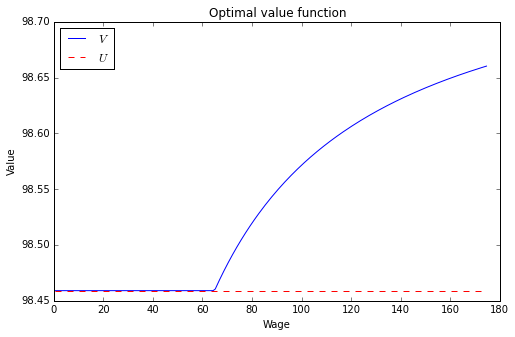

In [12]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(w, V, label=r'$V$')
ax.plot((w[0], w[-1]), (U, U), 'r--', label=r'$U$')
ax.set_xlabel('Wage')
ax.set_ylabel('Value')
ax.set_title('Optimal value function')
plt.legend(loc=2)
plt.show()

Performance comparison:

In [13]:
c = 40
%timeit js.solve(c=c)

10000 loops, best of 3: 58.7 µs per loop


In [14]:
%timeit js_ddp.solve(c=c)

100 loops, best of 3: 8.04 ms per loop


## Optimal unemployment insurance policy

We compute the optimal level of unemployment insurance
as in the [lecture](http://quant-econ.net/py/lake_model.html#fiscal-policy),
mimicking [lakemodel_example.py](https://github.com/QuantEcon/QuantEcon.py/blob/master/examples/lakemodel_example.py).

In [15]:
class UnemploymentInsurancePolicy(object):
    def __init__(self, w, pdf, beta, alpha=0, gamma=1, rho=0):
        self.w, self.pdf, self.beta, self.alpha, self.gamma, self.rho = \
            w, pdf, beta, alpha, gamma, rho
    
    def solve_job_search_model(self, c, T):
        js = JobSearchModel(self.w-T, self.pdf, self.beta,
                            self.alpha, self.gamma, self.rho)
        V, U, C = js.solve(c=c-T)
        pi = js.stationary_distribution(C)
        
        return V, U, C, pi
        
    def implement(self, c):
        
        def budget_balance(T):
            _, _, _, pi = self.solve_job_search_model(c, T)
            return T - pi[0]*c
        
        # Budget balancing tax given c
        T = scipy.optimize.brentq(budget_balance, 0, c)
        
        V, U, C, pi = self.solve_job_search_model(c, T)
        
        EV = (C*V).dot(self.pdf)/(C.dot(self.pdf))
        W = pi[0] * U + pi[1] * EV
        
        return T, W, pi

In [16]:
uip = UnemploymentInsurancePolicy(w, pdf, beta, alpha_q, gamma, rho)

In [17]:
grid_size = 501  #25
cvec = np.linspace(5, 135, grid_size)
Ts, Ws = np.empty(grid_size), np.empty(grid_size)
pis = np.empty((grid_size, 2))
for i, c in enumerate(cvec):
    T, W, pi = uip.implement(c=c)
    Ts[i], Ws[i], pis[i] = T, W, pi
i_max = Ws.argmax()
print('Optimal unemployment benefit:', cvec[i_max])

Optimal unemployment benefit: 67.4


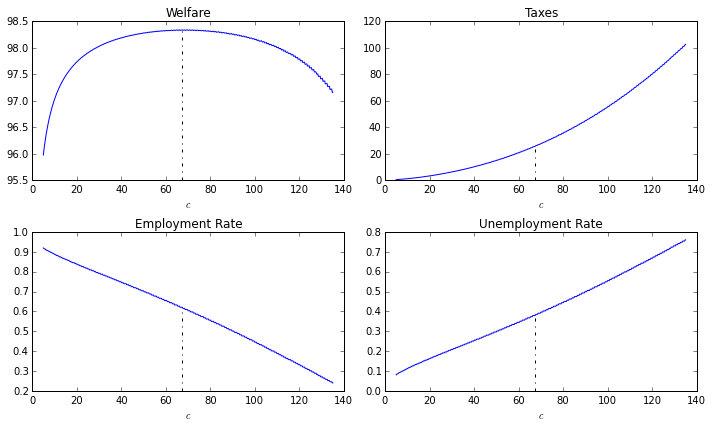

In [18]:
def plot(ax, y_vec, title):
    ax.plot(cvec, y_vec)
    ax.set_xlabel(r"$c$")
    ax.vlines(cvec[i_max], ax.get_ylim()[0], y_vec[i_max], "k", "-.")
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
plot(axes[0, 0], Ws, "Welfare")
plot(axes[0, 1], Ts, "Taxes")
plot(axes[1, 0], pis[:, 1], "Employment Rate")
plot(axes[1, 1], pis[:, 0], "Unemployment Rate")

plt.tight_layout()
plt.show()

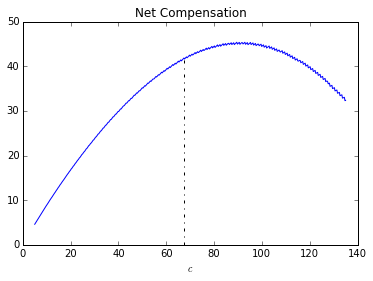

In [19]:
fig, ax = plt.subplots()
plot(ax, cvec-Ts, "Net Compensation")
plt.show()